In [2]:
import matplotlib.pyplot as plt
import torch
import os
from model.datamarts.ImageDatamart import ImageDatamart


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BatchSize = 256
Epochs = 30
ImageSize = 28
DatasetDir = "datamart"
ModelDir = 'models/'

{'Glioma': 1426, 'Meningioma': 708, 'Pituitary tumor': 930}
['Glioma', 'Meningioma', 'Pituitary tumor']


<BarContainer object of 3 artists>

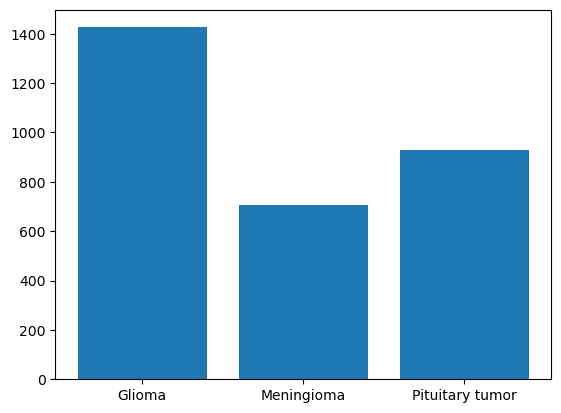

In [13]:
datamart = ImageDatamart("datamart")

print(datamart.data_per_category())
print(datamart.categories())
plt.bar(datamart.data_per_category().keys(), datamart.data_per_category().values())

In [6]:

from model.dataframes.ImageDataframe import ImageDataframe

dataframe = ImageDataframe(datamart)
print(dataframe.get().keys())
print(len(list(dataframe.get().values())[0]), len(list(dataframe.get().values())[1]))

dict_keys(['Input', 'Output'])
3064 3064


In [7]:
dataframe.load_images()

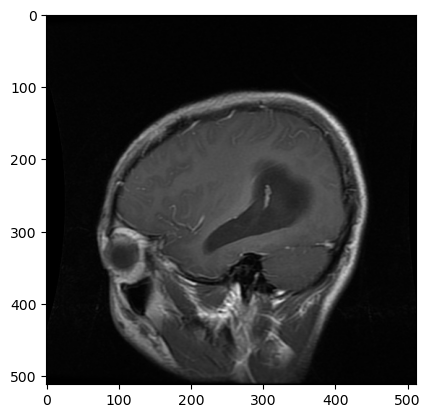

In [8]:
plt.imshow(dataframe.get()["Input"][100].content())

In [9]:
from model.mappers.ResizeImageMapper import ResizeImageMapper

resizer = ResizeImageMapper((100, 100))
resizer.apply(dataframe, column_name="Input", output_column_name="Resized Input")

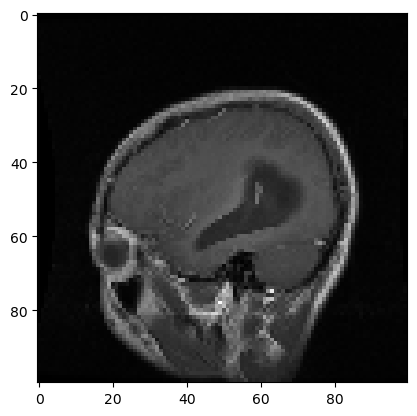

In [10]:
plt.imshow(dataframe.get()["Resized Input"][100].content())

In [11]:
from model.mappers.OneHotMapper import OneHotMapper

OneHotMapper().apply(dataframe, "Output")
dataframe.column_names()

['Input', 'Output', 'Resized Input', 'Meningioma', 'Pituitary tumor', 'Glioma']

In [14]:
print(sum(dataframe.get()["Glioma"]), sum(dataframe.get()["Meningioma"]), sum(dataframe.get()["Pituitary tumor"]))

1426 708 930
